Here we adjust torch_git to using a NN in every time step like in the OG paper of 

Han, Jiequn, Arnulf Jentzen, and Weinan E. “Solving High-Dimensional Partial Differential Equations Using Deep Learning.” Proceedings of the National Academy of Sciences 115, no. 34 (August 21, 2018): 8505–10. https://doi.org/10.1073/pnas.1718942115.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from parameterfree import COCOB

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class fbsde():
    def __init__(self, x_0, b, sigma, f, g, T, dim_x,dim_y,dim_d, guess_y_0 = [0,1] ):
        self.x_0 = x_0.to(device)
        self.b = b
        self.sigma = sigma
        self.f = f
        self.g = g
        self.T = T
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_d = dim_d
        self.guess_y_0 = guess_y_0 # range

class Model2(nn.Module):
    def __init__(self, equation, dim_h, N):
        super(Model2, self).__init__()
        self.equation= equation
        self.N = N
        # specifying parameters of NN
        l = torch.rand(equation.dim_y, device=device)
        self.y_0 = nn.Parameter(equation.guess_y_0[0]*l+ equation.guess_y_0[1]*(1-l))
        self.linear1 = nn.ModuleList([nn.Linear(equation.dim_x, dim_h) for _ in range(N)])
        self.linear2 = nn.ModuleList([nn.Linear(dim_h, dim_h) for _ in range(N)])
        self.bn = nn.ModuleList([nn.BatchNorm1d(dim_h) for _ in range(N)])
        self.linear4 = nn.ModuleList([nn.Linear(dim_h, equation.dim_y*equation.dim_d) for _ in range(N)])
    
    def get_z(self,x,i):
        x = F.gelu(self.linear1[i](x))
        x = self.bn[i](F.gelu(self.linear2[i](x)))
        x = F.gelu(self.linear2[i](x))
        return self.linear4[i](x).reshape(-1, self.equation.dim_y, self.equation.dim_d)
        

    def forward(self,batch_size):
        dt = self.equation.T / self.N
        x = self.equation.x_0+torch.zeros(batch_size,self.equation.dim_x,device=device)
        y = self.y_0+torch.zeros(batch_size,self.equation.dim_y,device=device)
        z = torch.zeros(batch_size, self.equation.dim_y, self.equation.dim_d, device=device)

        for i in range(self.N):
            t = dt*i
            z = self.get_z(x,i)+z 

            dW = torch.randn(batch_size, self.equation.dim_d, 1, device=device) * np.sqrt(dt)
            x = x+self.equation.b(t, x, y)*dt+torch.matmul( self.equation.sigma(t, x), dW).reshape(-1, self.equation.dim_x)
            y = y-self.equation.f(t, x, y, z)*dt + torch.matmul(z, dW).reshape(-1, self.equation.dim_y)
        return x, y


class BSDEsolver2():
    def __init__(self, equation, dim_h,N):
        self.model = Model2(equation,dim_h,N).to(device)
        self.equation = equation

    def train(self, batch_size, itr, log):
        criterion = torch.nn.MSELoss().to(device)
        # optimizer = torch.optim.Adam(self.model.parameters())
        optimizer = COCOB(self.model.parameters())
        loss_data, y0_data = [], []

        for i in range(itr):
            x, y = self.model(batch_size)
            loss = criterion(self.equation.g(x), y)
            loss_data.append(float(loss))
            y0_data.append(float(self.model.y_0))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if log and i%int(itr/20) == 0:
                print(f"loss: {float(loss):7.2f} y0: {float(self.model.y_0):7.2f} done: {i/itr*100:5.2f}% Iteration: {i}")
        return loss_data, y0_data
            

In [8]:

mu = 0.07
sig = 0.3
r = 0.02
K = 110
dim_x, dim_y, dim_d, dim_h, N, itr, batch_size = 1, 1, 1, 7, 40, 500, 1000
guess_y_0 = [14,14]

x_0, T = 100*torch.ones(dim_x), 1


def b(t, x, y):
    return mu*x.reshape(batch_size, dim_x)


def sigma(t, x):
    return sig*x.reshape(batch_size, dim_x, dim_d)

#f_american doesnt work
def f_american(t, x, y, z):
    return (-r*y + r*K* (y<=g(x))).reshape(batch_size, dim_y)

def f_europian(t, x, y, z):
    return (-r*y ).reshape(batch_size, dim_y)


def g(x):
    return torch.max(K-x, torch.zeros(batch_size, dim_y, device=device)) 


equation = fbsde(x_0, b, sigma, f_europian, g, T,dim_x, dim_y, dim_d, guess_y_0)

bsde_solver = BSDEsolver2(equation, dim_h,N)

loss:   24.96 y0:   14.09 done:  0.00% Iteration: 0
loss:   23.70 y0:   14.08 done:  5.00% Iteration: 10
loss:   21.48 y0:   14.06 done: 10.00% Iteration: 20
loss:   22.48 y0:   14.06 done: 15.00% Iteration: 30
loss:   20.48 y0:   14.07 done: 20.00% Iteration: 40
loss:   18.51 y0:   14.08 done: 25.00% Iteration: 50
loss:   20.70 y0:   14.07 done: 30.00% Iteration: 60
loss:   19.31 y0:   14.06 done: 35.00% Iteration: 70
loss:   22.90 y0:   14.07 done: 40.00% Iteration: 80
loss:   20.31 y0:   14.07 done: 45.00% Iteration: 90
loss:   20.76 y0:   14.07 done: 50.00% Iteration: 100
loss:   20.38 y0:   14.09 done: 55.00% Iteration: 110
loss:   18.23 y0:   14.08 done: 60.00% Iteration: 120
loss:   20.56 y0:   14.08 done: 65.00% Iteration: 130
loss:   21.21 y0:   14.08 done: 70.00% Iteration: 140
loss:   19.00 y0:   14.08 done: 75.00% Iteration: 150
loss:   18.72 y0:   14.08 done: 80.00% Iteration: 160
loss:   21.23 y0:   14.08 done: 85.00% Iteration: 170
loss:   20.11 y0:   14.09 done: 90.00% 

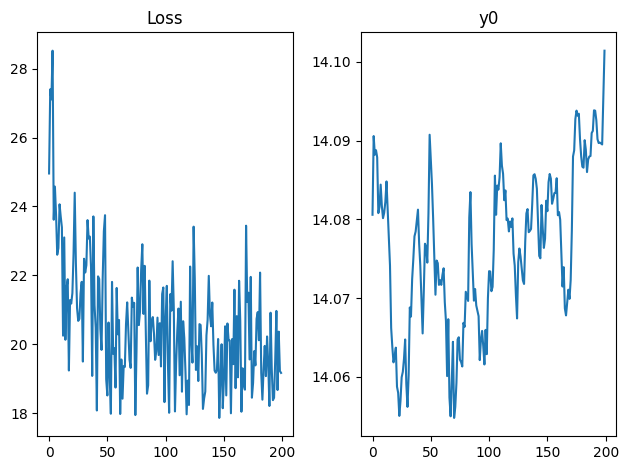

In [10]:

import matplotlib.pyplot as plt
itr = 200
# torch.manual_seed(44)
loss, y0=bsde_solver.train(batch_size, itr, log=True)

fig, axs = plt.subplots(1,2)
axs[0].plot(loss)
axs[0].set_title('Loss')

axs[1].plot(y0)
axs[1].set_title('y0')

plt.tight_layout()
plt.show()